In [1]:
%matplotlib inline
import os, sys

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
#from gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from keras_ex.gkernel.sklearn import RBFClassifier

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
X, y = digits.data, digits.target
X = X / 16
X.shape, X.min(), X.max()

((1797, 64), 0.0, 1.0)

In [4]:
y.shape

(1797,)

In [5]:
N = y.shape[0]
y2 = keras.utils.to_categorical(y, num_classes=10)
y2.shape
index = np.arange(N)
xtrain = X[index[index % 2 != 0],:]
ytrain = y2[index[index % 2 != 0]]
xtest = X[index[index % 2 == 0],:]
yans = y2[index[index % 2 == 0]]

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, Lasso
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import joblib

from lightgbm import LGBMClassifier

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
def f1_scorer(estimator, X, y):
    pred = estimator.predict(X)
    s = f1_score(y, pred, average='macro')
    return s

## BENCHMARK LogisticRegression

In [9]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [10]:
param_name = "C"
param_range = np.logspace(-3, 3, 7)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [11]:
%%time

train_scores, test_scores = validation_curve(
    LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000),
    xtrain, np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.3s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   0.9s
[CV] C=10.0 ..........................................................
[CV] ........................................... C=10.0, total=   3.5s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   3.9s
[CV] C=1000.0 ........................................................
[CV] ......................................... C=1000.0, total=   4.6s
[CV] C

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   44.8s finished


In [12]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 1.82850272e-02, 1.84427988e-02],
       [1.00000000e-02, 1.85683671e-02, 1.87916128e-02],
       [1.00000000e-01, 8.83084412e-01, 8.17783004e-01],
       [1.00000000e+00, 9.85584329e-01, 9.30447501e-01],
       [1.00000000e+01, 1.00000000e+00, 9.42338391e-01],
       [1.00000000e+02, 1.00000000e+00, 9.38957744e-01],
       [1.00000000e+03, 1.00000000e+00, 9.42460349e-01]])

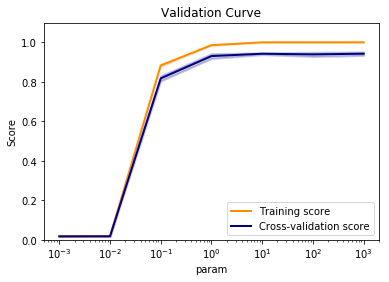

In [13]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [14]:
'''test data'''
est = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000, C=1000)
est.fit(xtrain, np.argmax(ytrain, axis=1))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
pred = est.predict(xtrain)

In [16]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.00        91

   micro avg       1.00      1.00      1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 93  0  0  0  0  0  0]
 [ 0  0  0  0 88  0  0  0  0  0]
 [ 0  0  0  0  0 91  0  0  0  0]
 [ 0  0  0  0  0  0 90  0  0

In [17]:
pred_test = est.predict(xtest)

In [18]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9621878550656187
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       0.94      0.90      0.92        93
           2       0.98      1.00      0.99        86
           3       0.97      0.99      0.98        90
           4       0.99      0.97      0.98        93
           5       0.94      0.98      0.96        91
           6       1.00      0.98      0.99        91
           7       0.97      0.98      0.97        88
           8       0.88      0.91      0.89        88
           9       0.96      0.92      0.94        89

   micro avg       0.96      0.96      0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 84  2  1  1  1  0  0  4  0]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  0 89  0  0  0  0  1  0]
 [ 0  0  0  0 90  0  0  1  0  2]
 [ 0  0  0  0  0 89  0  1  0  1]
 [ 0  0  0  0

## Bagging + Logit

In [19]:
from sklearn.ensemble import BaggingClassifier

In [20]:
clf = BaggingClassifier(
    LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000, C=1000),
    max_samples=0.5,
    verbose=2
)

In [21]:
clf.fit(xtrain, np.argmax(ytrain, axis=1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


BaggingClassifier(base_estimator=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.5, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=2, warm_start=False)

In [22]:
pred = clf.predict(xtrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [23]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9854419155239723
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       0.97      0.98      0.97        89
           2       0.99      0.99      0.99        91
           3       1.00      0.98      0.99        93
           4       0.99      0.99      0.99        88
           5       0.99      0.98      0.98        91
           6       0.99      1.00      0.99        90
           7       0.99      1.00      0.99        91
           8       0.97      0.97      0.97        86
           9       0.98      0.98      0.98        91

   micro avg       0.99      0.99      0.99       898
   macro avg       0.99      0.99      0.99       898
weighted avg       0.99      0.99      0.99       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 87  0  0  1  0  0  0  0  1]
 [ 0  1 90  0  0  0  0  0  0  0]
 [ 0  0  0 91  0  0  0  0  2  0]
 [ 0  0  0  0 87  0  0  1  0  0]
 [ 0  0  0  0  0 89  1  0  0  1]
 [ 0  0  0  0

In [24]:
pred_test = clf.predict(xtest)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [25]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9567136421538119
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       0.93      0.96      0.94        93
           2       0.99      1.00      0.99        86
           3       0.97      0.92      0.94        90
           4       1.00      0.97      0.98        93
           5       0.97      0.96      0.96        91
           6       0.99      0.98      0.98        91
           7       0.96      0.97      0.96        88
           8       0.86      0.90      0.88        88
           9       0.92      0.92      0.92        89

   micro avg       0.96      0.96      0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 89  1  1  0  0  0  0  2  0]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  0 83  0  0  0  1  6  0]
 [ 0  0  0  0 90  0  0  1  0  2]
 [ 0  1  0  0  0 87  0  1  0  2]
 [ 0  0  0  0

## BENCHMARK LGBMClassifier

In [26]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [27]:
param_name = "reg_alpha"
param_range = np.logspace(-3, 3, 7)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [28]:
%%time

train_scores, test_scores = validation_curve(
    LGBMClassifier(
        min_child_samples=20,
        reg_alpha=0.1
    ),
    xtrain, np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] reg_alpha=0.001 .................................................
[CV] .................................. reg_alpha=0.001, total=   0.1s
[CV] reg_alpha=0.01 ..................................................
[CV] ................................... reg_alpha=0.01, total=   0.0s
[CV] reg_alpha=0.1 ...................................................
[CV] .................................... reg_alpha=0.1, total=   0.0s
[CV] reg_alpha=1.0 ...................................................
[CV] .................................... reg_alpha=1.0, total=   0.0s
[CV] reg_alpha=10.0 ..................................................
[CV] ................................... reg_alpha=10.0, total=   0.0s
[CV] reg_alpha=100.0 .................................................
[CV] .................................. reg_alpha=100.0, total=   0.0s
[CV] reg_alpha=1000.0 ................................................
[CV] ................................. reg_alpha=1000.0, total=   0.0s
[CV] r

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.8s finished


In [29]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 9.55956073e-01, 8.54552386e-01],
       [1.00000000e-02, 9.55982579e-01, 8.53570294e-01],
       [1.00000000e-01, 9.54834065e-01, 8.54249974e-01],
       [1.00000000e+00, 9.41107282e-01, 8.56470400e-01],
       [1.00000000e+01, 9.04822161e-01, 8.25580827e-01],
       [1.00000000e+02, 1.78125000e-02, 1.79190751e-02],
       [1.00000000e+03, 1.78125000e-02, 1.79190751e-02]])

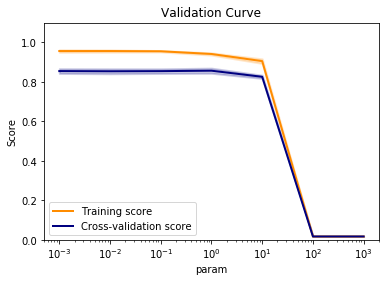

In [30]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [31]:
'''test data'''
est = LGBMClassifier(
        min_child_samples=20,
        reg_alpha=0.1
    )
est.fit(xtrain, np.argmax(ytrain, axis=1))

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=20,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='multiclass', reg_alpha=0.1, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1)

In [32]:
pred = est.predict(xtrain)

In [33]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9590311774708322
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        88
           1       0.91      0.96      0.93        89
           2       0.98      0.99      0.98        91
           3       0.92      0.97      0.94        93
           4       0.99      0.97      0.98        88
           5       0.98      0.95      0.96        91
           6       1.00      0.97      0.98        90
           7       0.95      0.96      0.95        91
           8       0.98      0.94      0.96        86
           9       0.92      0.90      0.91        91

   micro avg       0.96      0.96      0.96       898
   macro avg       0.96      0.96      0.96       898
weighted avg       0.96      0.96      0.96       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 85  0  2  0  1  0  0  0  1]
 [ 0  1 90  0  0  0  0  0  0  0]
 [ 0  1  1 90  0  0  0  1  0  0]
 [ 1  0  0  0 85  0  0  0  1  1]
 [ 0  1  0  0  0 86  0  0  0  4]
 [ 1  2  0  0

In [34]:
pred_test = est.predict(xtest)

In [35]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9003445134291959
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       0.91      0.87      0.89        93
           2       0.90      0.93      0.91        86
           3       0.84      0.87      0.85        90
           4       0.97      0.90      0.93        93
           5       0.87      0.85      0.86        91
           6       0.97      0.92      0.94        91
           7       0.92      0.94      0.93        88
           8       0.90      0.83      0.86        88
           9       0.77      0.89      0.82        89

   micro avg       0.90      0.90      0.90       899
   macro avg       0.90      0.90      0.90       899
weighted avg       0.90      0.90      0.90       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 81  2  6  0  1  0  0  0  3]
 [ 0  0 80  2  0  0  2  0  2  0]
 [ 0  1  1 78  0  2  1  0  2  5]
 [ 1  3  0  0 84  2  0  2  1  0]
 [ 0  1  0  2  1 77  0  1  0  9]
 [ 0  0  1  0

In [36]:
#clf = RBFClassifier(num_lm=3)
# clf = RBFClassifier(
#     num_lm=3,
#     lm=xtrain[:3]
# )
# clf = RBFClassifier(
#     num_lm=50,
#     lm=xtrain[:50],
#     make_model_gkernel=make_model_gkernel3
# )
# early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta=0.000, restore_best_weights=True)
# clf = RBFClassifier(
#     num_lm=3,
#     lm=xtrain[np.random.choice(np.arange(xtrain.shape[0]), 3)],
# )
# clf = RBFClassifier(
#     num_lm=10,
#     lm=xtrain[:10],
#     callbacks=[early_stopping],
#     make_model_gkernel=make_model_gkernel3
# )
# clf = RBFClassifier(
#     num_lm=3,
#     lm=xtrain[:3],
#     make_model_gkernel=make_model_gkernel3,
#     activation='sigmoid',
#     loss='binary_crossentropy'
# )
clf = RBFClassifier(
    num_lm=10,
    lm=xtrain[np.random.choice(np.arange(xtrain.shape[0]), 10)],
    reg_l1=0.00,
    epochs_warmup=0,
    random_state=101
)
clf

In [37]:
%%time
hst = clf.fit(xtrain, ytrain, epochs=500, batch_size=32, verbose=0)

W1007 21:42:56.165635 139666019788608 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1007 21:42:56.168868 139666019788608 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1007 21:42:56.201871 139666019788608 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1007 21:42:56.202932 139666019788608 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: T

CPU times: user 19.2 s, sys: 733 ms, total: 19.9 s
Wall time: 13.8 s


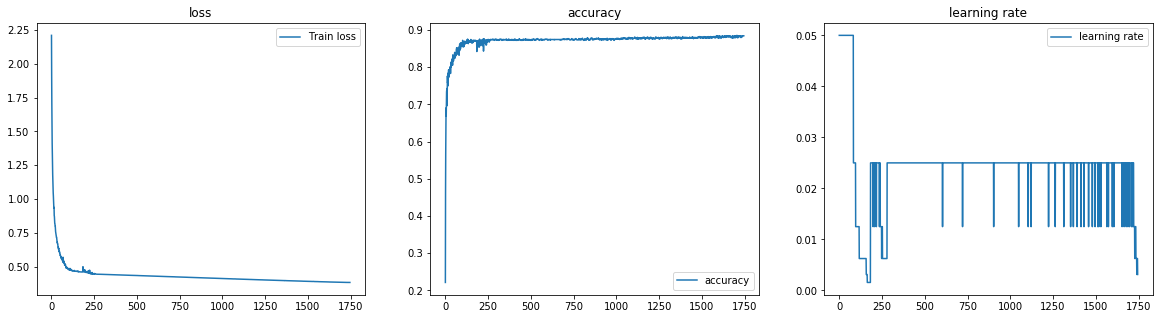

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [39]:
clf.n_classes_, clf.classes_

(10, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [40]:
clf.sk_params

{'callbacks': None,
 'epochs_warmup': 0,
 'lm': array([[0.    , 0.    , 0.0625, 0.5   , 0.625 , 0.5   , 0.1875, 0.    ,
         0.    , 0.    , 0.0625, 1.    , 1.    , 1.    , 0.5   , 0.    ,
         0.    , 0.    , 0.    , 0.875 , 1.    , 1.    , 0.1875, 0.    ,
         0.    , 0.    , 0.0625, 1.    , 1.    , 0.9375, 0.    , 0.    ,
         0.    , 0.    , 0.375 , 1.    , 1.    , 0.625 , 0.    , 0.    ,
         0.    , 0.    , 0.625 , 1.    , 0.9375, 0.25  , 0.    , 0.    ,
         0.    , 0.    , 0.5   , 1.    , 0.875 , 0.    , 0.    , 0.    ,
         0.    , 0.    , 0.0625, 0.5   , 0.5   , 0.0625, 0.    , 0.    ],
        [0.    , 0.    , 0.0625, 0.6875, 0.75  , 0.8125, 0.875 , 0.3125,
         0.    , 0.    , 0.4375, 0.9375, 0.6875, 0.625 , 1.    , 0.375 ,
         0.    , 0.    , 0.625 , 0.4375, 0.    , 0.125 , 1.    , 0.125 ,
         0.    , 0.0625, 1.    , 0.0625, 0.    , 0.75  , 0.5   , 0.    ,
         0.    , 0.125 , 0.6875, 0.    , 0.25  , 0.875 , 0.0625, 0.    ,
   

In [41]:
clf.__dict__

{'build_fn': <function keras_ex.gkernel.sklearn.make_model>,
 'classes_': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'model': <keras.engine.training.Model at 0x7f062c1841d0>,
 'n_classes_': 10,
 'sk_params': {'callbacks': None,
  'epochs_warmup': 0,
  'lm': array([[0.    , 0.    , 0.0625, 0.5   , 0.625 , 0.5   , 0.1875, 0.    ,
          0.    , 0.    , 0.0625, 1.    , 1.    , 1.    , 0.5   , 0.    ,
          0.    , 0.    , 0.    , 0.875 , 1.    , 1.    , 0.1875, 0.    ,
          0.    , 0.    , 0.0625, 1.    , 1.    , 0.9375, 0.    , 0.    ,
          0.    , 0.    , 0.375 , 1.    , 1.    , 0.625 , 0.    , 0.    ,
          0.    , 0.    , 0.625 , 1.    , 0.9375, 0.25  , 0.    , 0.    ,
          0.    , 0.    , 0.5   , 1.    , 0.875 , 0.    , 0.    , 0.    ,
          0.    , 0.    , 0.0625, 0.5   , 0.5   , 0.0625, 0.    , 0.    ],
         [0.    , 0.    , 0.0625, 0.6875, 0.75  , 0.8125, 0.875 , 0.3125,
          0.    , 0.    , 0.4375, 0.9375, 0.6875, 0.625 , 1.    , 0.375 ,
      

In [42]:
clf.current_gamma()

0.12742019

In [43]:
clf.predict(xtrain)[:10]

array([1, 3, 9, 7, 9, 1, 3, 5, 7, 9])

In [44]:
clf.predict_proba(xtest)[:5]

array([[9.1468138e-01, 8.4039311e-06, 4.5567128e-04, 5.3453882e-04,
        2.8018944e-04, 1.3812830e-02, 7.8249857e-04, 6.9661706e-04,
        1.3504312e-03, 6.7397468e-02],
       [5.2176820e-06, 9.2692792e-01, 2.0529335e-02, 4.8422485e-04,
        2.9939795e-03, 3.7233619e-08, 1.8616182e-03, 1.5215502e-03,
        4.4759486e-02, 9.1653474e-04],
       [2.7924698e-02, 7.6123573e-02, 3.4091123e-03, 4.7665995e-05,
        7.5403070e-01, 8.1517865e-05, 1.1626248e-01, 8.2886247e-03,
        3.6873883e-03, 1.0144264e-02],
       [5.6063343e-02, 2.1960810e-01, 4.5373552e-03, 9.9652592e-05,
        2.9640762e-02, 3.1068806e-02, 5.6633246e-01, 8.5504587e-05,
        8.8009812e-02, 4.5541101e-03],
       [2.1709709e-03, 4.8946593e-02, 6.8427406e-02, 3.4107003e-02,
        3.3180770e-06, 6.9332928e-05, 6.0126297e-03, 3.3549572e-05,
        8.3518708e-01, 5.0421739e-03]], dtype=float32)

In [45]:
clf.score(xtrain, ytrain)

898/898 [==============================] - 0s 167us/step


0.8819599109131403

In [46]:
clf.score(xtest, yans)

899/899 [==============================] - 0s 24us/step


0.8654060067403834

In [47]:
print('F1_SCORE :', f1_score(np.argmax(ytrain,axis=1), clf.predict(xtrain), average='macro'))
print(classification_report(np.argmax(ytrain,axis=1), clf.predict(xtrain)))
print(confusion_matrix(np.argmax(ytrain,axis=1), clf.predict(xtrain)))

F1_SCORE : 0.8812734028165995
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        88
           1       0.83      0.90      0.86        89
           2       0.89      0.88      0.88        91
           3       0.87      0.84      0.85        93
           4       0.92      0.94      0.93        88
           5       0.97      0.93      0.95        91
           6       0.88      0.93      0.91        90
           7       0.96      0.98      0.97        91
           8       0.85      0.74      0.80        86
           9       0.75      0.77      0.76        91

   micro avg       0.88      0.88      0.88       898
   macro avg       0.88      0.88      0.88       898
weighted avg       0.88      0.88      0.88       898

[[79  0  0  0  3  2  3  0  0  1]
 [ 0 80  2  0  0  0  1  0  2  4]
 [ 0  4 80  3  0  0  1  1  2  0]
 [ 0  0  3 78  0  0  0  1  3  8]
 [ 1  1  1  0 83  0  2  0  0  0]
 [ 1  0  0  0  1 85  1  0  0  3]
 [ 1  3  0  0

In [48]:
print('F1_SCORE :', f1_score(np.argmax(yans,axis=1), clf.predict(xtest), average='macro'))
print(classification_report(np.argmax(yans,axis=1), clf.predict(xtest)))
print(confusion_matrix(np.argmax(yans,axis=1), clf.predict(xtest)))

F1_SCORE : 0.8655623578311538
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        90
           1       0.83      0.90      0.87        93
           2       0.94      0.84      0.88        86
           3       0.86      0.82      0.84        90
           4       0.92      0.86      0.89        93
           5       0.88      0.89      0.89        91
           6       0.94      0.90      0.92        91
           7       0.91      0.95      0.93        88
           8       0.77      0.78      0.78        88
           9       0.71      0.75      0.73        89

   micro avg       0.87      0.87      0.87       899
   macro avg       0.87      0.86      0.87       899
weighted avg       0.87      0.87      0.87       899

[[85  0  0  0  3  0  1  0  0  1]
 [ 0 84  0  0  1  1  1  0  1  5]
 [ 0  2 72  1  0  0  1  1  4  5]
 [ 0  0  0 74  0  0  0  2 10  4]
 [ 1  5  0  0 80  1  1  4  1  0]
 [ 2  0  0  0  0 81  1  0  2  5]
 [ 3  2  0  0

In [49]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [50]:
param_name = "num_lm"
param_range = [2, 5, 10, 20, 50, 100, 150, 200, 250, 300]
param_range

[2, 5, 10, 20, 50, 100, 150, 200, 250, 300]

In [51]:
%%time

def f1_scorer_2(estimator, X, y):
    pred = estimator.predict(X)
    s = f1_score(np.argmax(y, axis=1), pred, average='macro')
    return s

train_scores, test_scores = validation_curve(
    RBFClassifier(
        num_lm=2,
        lm_select_from_x=True,
        random_state=None,
        gamma='scale',
        epochs=500, batch_size=100, verbose=0
    ),
    xtrain, ytrain,
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer_2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] num_lm=2 ........................................................
[CV] ......................................... num_lm=2, total=   5.1s
[CV] num_lm=5 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] ......................................... num_lm=5, total=   8.0s
[CV] num_lm=10 .......................................................
[CV] ........................................ num_lm=10, total=  13.4s
[CV] num_lm=20 .......................................................
[CV] ........................................ num_lm=20, total=  14.4s
[CV] num_lm=50 .......................................................
[CV] ........................................ num_lm=50, total=   6.3s
[CV] num_lm=100 ......................................................
[CV] ....................................... num_lm=100, total=   5.9s
[CV] num_lm=150 ......................................................
[CV] ....................................... num_lm=150, total=   5.8s
[CV] num_lm=200 ......................................................
[CV] ....................................... num_lm=200, total=   6.3s
[CV] num_lm=250 ......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.4min finished


In [52]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[  2.        ,   0.36847661,   0.38326176],
       [  5.        ,   0.69846286,   0.67757362],
       [ 10.        ,   0.89081798,   0.85652516],
       [ 20.        ,   0.96969917,   0.90810365],
       [ 50.        ,   0.99651218,   0.94751892],
       [100.        ,   0.99943499,   0.95780381],
       [150.        ,   0.99943499,   0.95983336],
       [200.        ,   1.        ,   0.95346742],
       [250.        ,   1.        ,   0.95571872],
       [300.        ,   1.        ,   0.96194792]])

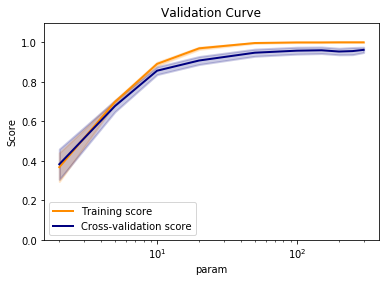

In [53]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [54]:
%%time

'''test data'''
est = RBFClassifier(
    num_lm=200,
    lm_select_from_x=True,
    random_state=None,
    gamma='scale',
    lr=0.05,
    epochs=500, batch_size=100, verbose=0
)
hst = est.fit(xtrain, ytrain)

CPU times: user 10.6 s, sys: 284 ms, total: 10.9 s
Wall time: 8.49 s


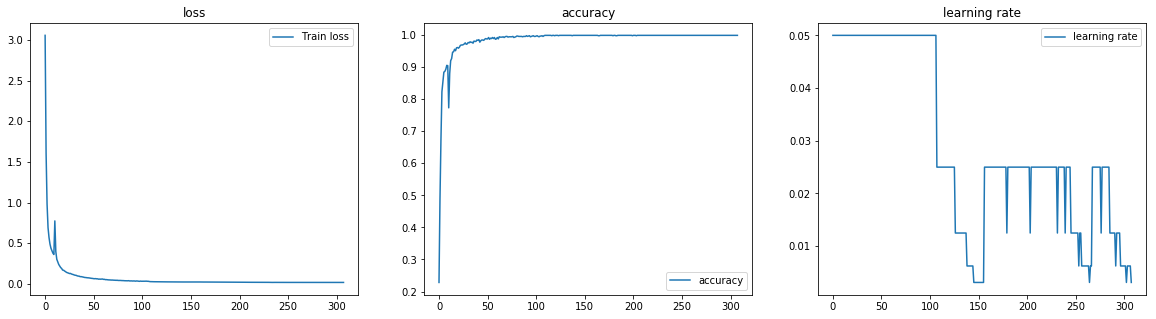

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [56]:
pred = est.predict(xtrain)

In [57]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9989010657247231
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        88
           5       1.00      0.99      0.99        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        86
           9       0.99      1.00      0.99        91

   micro avg       1.00      1.00      1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 93  0  0  0  0  0  0]
 [ 0  0  0  0 88  0  0  0  0  0]
 [ 0  0  0  0  0 90  0  0  0  1]
 [ 0  0  0  0

In [58]:
pred_test = est.predict(xtest)

In [59]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9778087814110992
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      0.96      0.98        93
           2       0.99      1.00      0.99        86
           3       0.96      0.99      0.97        90
           4       0.99      0.98      0.98        93
           5       0.96      0.97      0.96        91
           6       1.00      0.97      0.98        91
           7       0.98      0.98      0.98        88
           8       0.96      0.99      0.97        88
           9       0.96      0.96      0.96        89

   micro avg       0.98      0.98      0.98       899
   macro avg       0.98      0.98      0.98       899
weighted avg       0.98      0.98      0.98       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 89  1  0  0  1  0  0  1  1]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  0 89  0  0  0  0  1  0]
 [ 0  0  0  0 91  0  0  1  0  1]
 [ 0  0  0  1  1 88  0  0  0  1]
 [ 0  0  0  0

In [60]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, Lasso
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import joblib

In [61]:
%%time

ins_splitter = StratifiedShuffleSplit(n_splits=50, test_size=0.5, random_state=0)
var_idx_all = np.arange(xtrain.shape[1])
threshold = 0.95
#threshold = 0.30
importances = np.zeros((xtrain.shape[1],))
predictions = pd.DataFrame()
#preds_all = pd.DataFrame()
pred_all_list = []
pred_train_all_list = []
counter = 0
np.random.seed(10001)

print("counter  | val_f1    |  val_r2    ")
print("---------------------------------------------")


for train_index, val_index in ins_splitter.split(xtrain, ytrain):
    x_train_tr, x_train_val = xtrain[train_index], xtrain[val_index]
    y_train_tr, y_train_val = ytrain[train_index], ytrain[val_index]
    
    
    #estimator = LGBMRegressor(min_child_samples=50, reg_alpha=100)
    estimator = RBFClassifier(
        num_lm=250,
        lm_select_from_x=True,
        random_state=None,
        gamma='scale',
        epochs=500, batch_size=100, verbose=0
    )
    estimator.fit(x_train_tr, y_train_tr)
    
    # score our fitted model on validation data
    val_y_pred = estimator.predict(x_train_val)
    val_mse = mean_squared_error(np.argmax(y_train_val,axis=1), val_y_pred)
    val_mae = mean_absolute_error(np.argmax(y_train_val,axis=1), val_y_pred)
    val_kappa = 0.0
    val_f1 = f1_score(np.argmax(y_train_val,axis=1), val_y_pred, average='macro')
    val_cos = cosine_similarity(np.argmax(y_train_val,axis=1).reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_dst = euclidean_distances(np.argmax(y_train_val,axis=1).reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_r2  = r2_score(np.argmax(y_train_val,axis=1), val_y_pred)
    gamma = estimator.current_gamma()
    
    if val_f1 > threshold:
        message = '<-- OK'
        pred_train_all = estimator.predict_proba(xtrain)
        pred_train_all_list.append(pred_train_all)
        pred_all = estimator.predict_proba(xtest)
        pred_all_list.append(pred_all)
        #preds_all = pd.concat([preds_all, pd.DataFrame(pred_all)], axis=1)
        #prediction = grid_search.best_estimator_.predict(x_test0)
        #predictions = pd.concat([predictions, pd.DataFrame(prediction)], axis=1)
        #importances += estimator.feature_importances_
        #filename = 'model-{}.sav'.format(counter)
        #joblib.dump(estimator, filename)
    else:
        message = '<-- skipping'

    print("{0:5}    |  {3:.4f}   |  {4:.4f}   {5:5e} {7}  ".format(
        counter,
        val_mse,
        val_mae,
        val_f1,
        val_r2,
        gamma,
        0,
        message))
    
    counter += 1

counter  | val_f1    |  val_r2    
---------------------------------------------
    0    |  0.9466   |  0.8448   2.042344e-01 <-- skipping  
    1    |  0.9689   |  0.9346   2.047463e-01 <-- OK  
    2    |  0.9531   |  0.8491   2.096595e-01 <-- OK  
    3    |  0.9665   |  0.9333   1.984935e-01 <-- OK  
    4    |  0.9598   |  0.8491   1.929194e-01 <-- OK  
    5    |  0.9458   |  0.8692   1.881472e-01 <-- skipping  
    6    |  0.9576   |  0.8977   2.046767e-01 <-- OK  
    7    |  0.9568   |  0.8583   1.886970e-01 <-- OK  
    8    |  0.9556   |  0.9201   2.171491e-01 <-- OK  
    9    |  0.9479   |  0.8735   1.913393e-01 <-- skipping  
   10    |  0.9710   |  0.9453   2.242026e-01 <-- OK  
   11    |  0.9625   |  0.8650   2.109069e-01 <-- OK  
   12    |  0.9642   |  0.9257   2.016720e-01 <-- OK  
   13    |  0.9422   |  0.7837   1.686132e-01 <-- skipping  
   14    |  0.9621   |  0.9130   2.080104e-01 <-- OK  
   15    |  0.9506   |  0.9011   1.960699e-01 <-- OK  
   16    |  0.9

In [62]:
for ee in pred_train_all_list:
    print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), np.argmax(ee, axis=1), average='macro'))

F1_SCORE : 0.9843814061315218
F1_SCORE : 0.9766494995278159
F1_SCORE : 0.983245305994598
F1_SCORE : 0.9799359173610178
F1_SCORE : 0.9787525732258204
F1_SCORE : 0.9785188501427335
F1_SCORE : 0.9777209135947897
F1_SCORE : 0.9854984183870931
F1_SCORE : 0.981170329642681
F1_SCORE : 0.9821219848161175
F1_SCORE : 0.9810373949200019
F1_SCORE : 0.9753214733538835
F1_SCORE : 0.9778843310677836
F1_SCORE : 0.9765544487196532
F1_SCORE : 0.9798866106748626
F1_SCORE : 0.9808489936543838
F1_SCORE : 0.9788266371133307
F1_SCORE : 0.9821631185074269
F1_SCORE : 0.9808319267476184
F1_SCORE : 0.9810536012203064
F1_SCORE : 0.9755105586755224
F1_SCORE : 0.9843842252950624
F1_SCORE : 0.981047724063919
F1_SCORE : 0.9799152022708114
F1_SCORE : 0.9775434064859361
F1_SCORE : 0.976524162263565
F1_SCORE : 0.9765024144891511
F1_SCORE : 0.9787372513779674
F1_SCORE : 0.9833298373083931
F1_SCORE : 0.9786434305975205
F1_SCORE : 0.9787671323308391
F1_SCORE : 0.9753059552583465
F1_SCORE : 0.9854569869661983
F1_SCORE : 0.9

In [63]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), np.argmax(np.stack(pred_train_all_list).mean(axis=0), axis=1), average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), np.argmax(np.stack(pred_train_all_list).mean(axis=0), axis=1)))
print(confusion_matrix(np.argmax(ytrain, axis=1), np.argmax(np.stack(pred_train_all_list).mean(axis=0), axis=1)))

F1_SCORE : 0.9955661646403187
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      0.99      0.99        89
           2       1.00      1.00      1.00        91
           3       1.00      0.99      0.99        93
           4       1.00      1.00      1.00        88
           5       0.99      0.99      0.99        91
           6       0.99      1.00      0.99        90
           7       1.00      1.00      1.00        91
           8       0.99      1.00      0.99        86
           9       0.99      0.99      0.99        91

   micro avg       1.00      1.00      1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 88  0  0  0  0  1  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 92  0  1  0  0  0  0]
 [ 0  0  0  0 88  0  0  0  0  0]
 [ 0  0  0  0  0 90  0  0  0  1]
 [ 0  0  0  0

In [64]:
np.stack(pred_all_list).mean(axis=0).shape

(899, 10)

In [65]:
for ee in pred_all_list:
    print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), np.argmax(ee, axis=1), average='macro'))

F1_SCORE : 0.966899894243593
F1_SCORE : 0.9590422955786078
F1_SCORE : 0.9622018226652072
F1_SCORE : 0.9545989972751373
F1_SCORE : 0.951426501057625
F1_SCORE : 0.9621660725273378
F1_SCORE : 0.9647924269332039
F1_SCORE : 0.9688346312641907
F1_SCORE : 0.958899890226434
F1_SCORE : 0.9598887292979248
F1_SCORE : 0.9611874407717268
F1_SCORE : 0.9621980829677869
F1_SCORE : 0.9656664416481661
F1_SCORE : 0.9690112697005085
F1_SCORE : 0.974332276976764
F1_SCORE : 0.967714803083565
F1_SCORE : 0.9545576868735962
F1_SCORE : 0.960075388863508
F1_SCORE : 0.963234068931451
F1_SCORE : 0.970097837557414
F1_SCORE : 0.9700830169072605
F1_SCORE : 0.9722294689030555
F1_SCORE : 0.9610973551299338
F1_SCORE : 0.9577547760552372
F1_SCORE : 0.9644094530436812
F1_SCORE : 0.9601058254122157
F1_SCORE : 0.9621901652377003
F1_SCORE : 0.9645692820451025
F1_SCORE : 0.9656675113756155
F1_SCORE : 0.9588578039401648
F1_SCORE : 0.9767014356495402
F1_SCORE : 0.9577642880716155
F1_SCORE : 0.967829548547469
F1_SCORE : 0.964792

In [66]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), np.argmax(np.stack(pred_all_list).mean(axis=0), axis=1), average='macro'))
print(classification_report(np.argmax(yans, axis=1), np.argmax(np.stack(pred_all_list).mean(axis=0), axis=1)))
print(confusion_matrix(np.argmax(yans, axis=1), np.argmax(np.stack(pred_all_list).mean(axis=0), axis=1)))

F1_SCORE : 0.9745130787454475
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      0.96      0.98        93
           2       0.99      1.00      0.99        86
           3       0.99      0.98      0.98        90
           4       0.99      0.97      0.98        93
           5       0.95      0.96      0.95        91
           6       0.99      0.97      0.98        91
           7       0.97      0.97      0.97        88
           8       0.94      0.99      0.96        88
           9       0.95      0.97      0.96        89

   micro avg       0.97      0.97      0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 89  1  0  0  1  1  0  0  1]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  0 88  0  0  0  1  1  0]
 [ 0  0  0  0 90  0  0  1  1  1]
 [ 0  0  0  1  1 87  0  0  0  2]
 [ 0  0  0  0

## validation_curve + LogisticRegression

In [67]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [68]:
param_name = "C"
param_range = np.logspace(-3, 5, 9)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05])

In [69]:
def f1_scorer(estimator, X, y):
    pred = estimator.predict(X)
    s = f1_score(y, pred, average='macro')
    return s

In [70]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
%%time

train_scores, test_scores = validation_curve(
    LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000),
    np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  40.0s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=  51.7s
[CV] C=10.0 ..........................................................
[CV] ........................................... C=10.0, total=  49.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total= 1.1min
[CV] C=1000.0 ........................................................
[CV] ......................................... C=1000.0, total=  42.9s
[CV] C

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 14.4min finished


In [72]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 1.83800623e-02, 1.84438040e-02],
       [1.00000000e-02, 1.85683671e-02, 1.87916128e-02],
       [1.00000000e-01, 1.00000000e+00, 9.82834973e-01],
       [1.00000000e+00, 1.00000000e+00, 9.83910521e-01],
       [1.00000000e+01, 1.00000000e+00, 9.86108489e-01],
       [1.00000000e+02, 1.00000000e+00, 9.92537881e-01],
       [1.00000000e+03, 1.00000000e+00, 9.93614498e-01],
       [1.00000000e+04, 1.00000000e+00, 9.94673232e-01],
       [1.00000000e+05, 1.00000000e+00, 9.93648125e-01]])

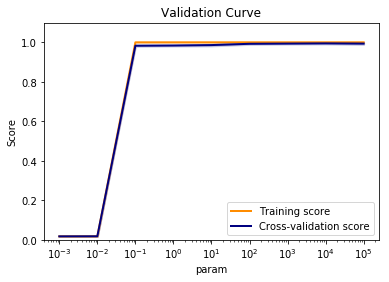

In [73]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [74]:
'''test data'''
est = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000, C=100000)
est.fit(np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1))

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)

In [75]:
pred = est.predict(np.hstack(pred_train_all_list))

In [76]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.00        91

   micro avg       1.00      1.00      1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 93  0  0  0  0  0  0]
 [ 0  0  0  0 88  0  0  0  0  0]
 [ 0  0  0  0  0 91  0  0  0  0]
 [ 0  0  0  0  0  0 90  0  0

In [77]:
pred_test = est.predict(np.hstack(pred_all_list))

In [78]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9778088040651787
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      0.97      0.98        93
           2       0.99      1.00      0.99        86
           3       0.98      0.99      0.98        90
           4       0.99      0.98      0.98        93
           5       0.95      0.96      0.95        91
           6       1.00      0.97      0.98        91
           7       0.97      0.97      0.97        88
           8       0.97      0.99      0.98        88
           9       0.95      0.97      0.96        89

   micro avg       0.98      0.98      0.98       899
   macro avg       0.98      0.98      0.98       899
weighted avg       0.98      0.98      0.98       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 90  1  0  0  1  0  0  0  1]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  0 89  0  0  0  1  0  0]
 [ 0  0  0  0 91  0  0  1  0  1]
 [ 0  0  0  1  1 87  0  0  0  2]
 [ 0  0  0  0

## validation_curve + LGBMClassifier

In [79]:
'''LGBMClassifier'''
from lightgbm import LGBMClassifier

param_name = "reg_alpha"
param_range = np.logspace(-3, 3, 7)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [80]:
%%time

train_scores, test_scores = validation_curve(
    LGBMClassifier(
        min_child_samples=20,
        reg_alpha=0.1
    ),
    np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. reg_alpha=0.001, total=   0.2s
[CV] reg_alpha=0.01 ..................................................
[CV] ................................... reg_alpha=0.01, total=   0.2s
[CV] reg_alpha=0.1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .................................... reg_alpha=0.1, total=   0.1s
[CV] reg_alpha=1.0 ...................................................
[CV] .................................... reg_alpha=1.0, total=   0.2s
[CV] reg_alpha=10.0 ..................................................
[CV] ................................... reg_alpha=10.0, total=   0.1s
[CV] reg_alpha=100.0 .................................................
[CV] .................................. reg_alpha=100.0, total=   0.1s
[CV] reg_alpha=1000.0 ................................................
[CV] ................................. reg_alpha=1000.0, total=   0.1s
[CV] reg_alpha=0.001 .................................................
[CV] .................................. reg_alpha=0.001, total=   0.2s
[CV] reg_alpha=0.01 ..................................................
[CV] ................................... reg_alpha=0.01, total=   0.2s
[CV] reg_alpha=0.1 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.0s finished


In [81]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 1.00000000e+00, 9.81762045e-01],
       [1.00000000e-02, 1.00000000e+00, 9.81778070e-01],
       [1.00000000e-01, 1.00000000e+00, 9.81778070e-01],
       [1.00000000e+00, 1.00000000e+00, 9.81726197e-01],
       [1.00000000e+01, 1.00000000e+00, 9.81761960e-01],
       [1.00000000e+02, 1.78125000e-02, 1.79190751e-02],
       [1.00000000e+03, 1.78125000e-02, 1.79190751e-02]])

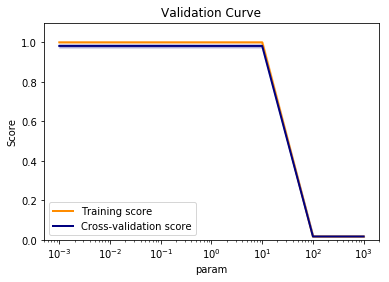

In [82]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [83]:
'''test data'''
est = LGBMClassifier(
        min_child_samples=50,
        reg_alpha=0.01
    )
est.fit(np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1))

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=50,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='multiclass', reg_alpha=0.01,
        reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

In [84]:
pred = est.predict(np.hstack(pred_train_all_list))

In [85]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.00        91

   micro avg       1.00      1.00      1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 93  0  0  0  0  0  0]
 [ 0  0  0  0 88  0  0  0  0  0]
 [ 0  0  0  0  0 91  0  0  0  0]
 [ 0  0  0  0  0  0 90  0  0

In [86]:
pred_test = est.predict(np.hstack(pred_all_list))

In [87]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.967707297322106
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        90
           1       1.00      0.95      0.97        93
           2       0.98      1.00      0.99        86
           3       0.96      0.98      0.97        90
           4       0.99      0.98      0.98        93
           5       0.94      0.97      0.95        91
           6       1.00      0.92      0.96        91
           7       0.97      0.97      0.97        88
           8       0.94      0.99      0.96        88
           9       0.95      0.93      0.94        89

   micro avg       0.97      0.97      0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 88  1  0  0  1  0  0  2  1]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  1 88  0  0  0  1  0  0]
 [ 0  0  0  0 91  0  0  1  0  1]
 [ 0  0  0  1  1 88  0  0  0  1]
 [ 2  0  0  0 